# Practical 10: Technology adjusted Carbon Based Accounting

Objectives
- Calculate TCBA
- Calculate Scope 1, 2, 3 emissions
- Visualize results

**Technology adjusted consumption-based accounting**

- In the [supplementary Information](https://static-content.springer.com/esm/art%3A10.1038%2Fnclimate2555/MediaObjects/41558_2015_BFnclimate2555_MOESM453_ESM.xlsx) file of [Kander et al. (2015), *National greenhouse-gas accounting for effective climate policy on international trade*](https://www.nature.com/articles/nclimate2555#Tab1), the authors illustrated the TCBA calculation and results in a spreadsheet.

- Download and go through the spreadsheet example to further understand the TCBA calculations. 

- Implement the same calculations in Python


In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Exercise 1: Calculate and visualize CBA vs TCBA

### 1.1 Import the downloaded data

In [2]:
# Import exiobase
data_file = 'data/41558_2015_BFnclimate2555_MOESM453_ESM.xlsx'    # add name of folder where data is stored

Z_df = pd.read_excel(data_file, sheet_name='TCBA Example', header = 2, usecols='C:N', nrows=12)
Z = Z_df.values

Y_df = pd.read_excel(data_file, sheet_name='TCBA Example', header = 2, usecols='P:R', nrows=12)
Y = Y_df.values

V_df = pd.read_excel(data_file, sheet_name='TCBA Example', header = 15, usecols='C:N', nrows=3)
V_df = V_df.fillna(0)
V = V_df.values

F_df = pd.read_excel(data_file, sheet_name='TCBA Example', header = 21, usecols='C:N', nrows=1)
F = F_df.values


### 1.2 Calculate other IO variables

In [3]:
r = 3                                  # number of regions
s = 4                                  # number of sectors
x = np.sum(Z,1) + np.sum(Y,1)
f = F/x.transpose()
A = Z/x.transpose()
I = np.eye(r*s)
L = np.linalg.inv(I - A)

### 1.3 TCBA calculations

#### 1.3.1 Export-related output

In [4]:
x_mult = L@Y                          # output multiplier
ex = x_mult.copy()
for i in range(0,r):                  # 3 regions
    ex[i*s : (i+1)*s,i] = 0           # remove domestic trasactions
ex = ex.sum(1)

#### 1.3.2 Export-related emissions

In [5]:
# Export-related emissions    
F_ex = f*ex

#### 1.3.3 Calculate 'World market average emissions multiplier'

In [6]:
f_wa = np.zeros((1,s))
for j in range(0,s):                   # 4 sectors
    ex_j = 0                           # export-related output of sector j
    F_ex_j = 0                         # export-related emissions of sector j
    for i in range(0,r):               # 3 regions
        ex_j += ex[i*s+j]
        F_ex_j += F_ex[0,i*s+j]
    f_wa[0,j] = F_ex_j/ex_j
f_wa = np.tile(f_wa,3)                  # replicate 3 times to build the new f for TCBA

#### 1.3.4 Export-related emissions by TCBA

In [7]:
# Export-related emissions by TCBA  
F_ex_TCBA = f_wa*ex

#### 1.3.5 Adjust export-related emissions (i.e. TCBA)

In [8]:
CBA = f @ L @ Y                                          # note F_hh is neglected in this example

diff_ex = F_ex - F_ex_TCBA
diff_ex_r = np.zeros((1,r))                              # aggregate by region
for i in range(0,r):
    diff_ex_r[0,i] = diff_ex[0,i*s:(i+1)*s].sum()

TCBA = CBA + diff_ex_r

### 1.4 Visualize results

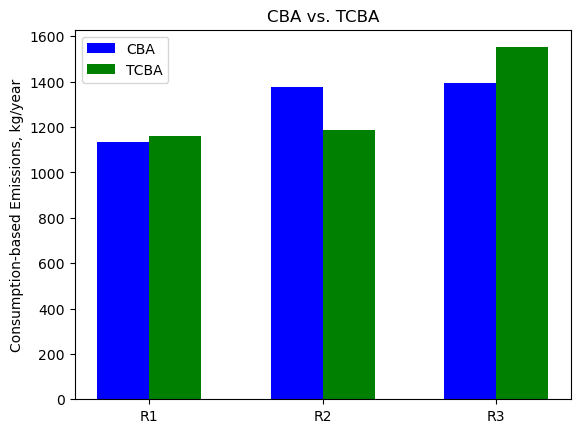

In [9]:
data = np.concatenate((CBA,TCBA))
X_pos = np.arange(3)+0.15                        # x-axis position variable
fig = plt.figure()
#ax = fig.add_axes([0,0,1,1])
plt.bar(X_pos - 0.15, data[0], color = 'b', width = 0.3)
plt.bar(X_pos + 0.15, data[1], color = 'g', width = 0.3)
plt.ylabel('Consumption-based Emissions, kg/year')
plt.title('CBA vs. TCBA')
plt.xticks(X_pos, ['R1', 'R2', 'R3'])
plt.legend(labels=['CBA', 'TCBA'])

## Exercise 2: Calculate emissions in the different scopes using exiobase

### 2.1 Import exiobase and calculate all the IO variables

In [10]:
# Import exiobase
path = 'data/IOT_2019_pxp/'    # add name of folder where data is stored                                
A = pd.read_csv(f'{path}A.txt', sep='\t', index_col=[0, 1], header=[0, 1])  # A matrix
Y = pd.read_csv(f'{path}Y.txt', sep='\t', index_col=[0, 1], header=[0, 1])  # Y matrix
F = pd.read_csv(f'{path}satellite/F.txt', sep='\t', index_col=[0], header=[0, 1])  # satellite matrix
F_hh = pd.read_csv(f'{path}satellite/F_Y.txt', sep='\t', index_col=[0], header=[0, 1])  # satellite for FD matrix

In [11]:
# calculate the Leontief inverse
I = np.identity(A.shape[0])
L = np.linalg.inv(I - A)

# Calculate total output vector (x)
y_total = Y.sum(1)
x = L @ y_total

In [12]:
# Get the CO2 emissions by combustion ("CO2 - combustion - air")
F_CO2 = F.loc["CO2 - combustion - air"]

In [13]:
# we make a copy of our product output vector
x_ = x.copy() 

# we divide 1 by the values that are non-0
x_[x_!=0] = 1/x_[x_!=0]

# We diagolize the resulting vector
inv_diag_x = np.diag(x_)


In [14]:
f_CO2 = F_CO2 @ inv_diag_x

#### 2.2 Calculate CO2 multiplier from exiobase data

In [15]:
f_CO2_mult = f_CO2 @ L

In [16]:
F_CO2_ind = f_CO2_mult @ A @ np.diag(x)

#### 2.3 Import IPCC data

In [17]:
ipcc_data = "data/IPCCsec.xlsx"
# import the xio2detail data
IPCCagg = pd.read_excel(ipcc_data, "xio2detail", header=0, usecols="A:H")
IPCCagg = IPCCagg.set_index("B2:H201")  # Set the first column as the index.
IPCCagg = IPCCagg.rename_axis(None, axis=0)  # Remove the 'B2:H201' name, this is only used for MATLAB code.
IPCCagg = IPCCagg.fillna(0)  # Change NaN into 0.

# This is what the data looks like:
IPCCagg.head()

,Energy,Transport,Materials,Industry,Services,Buildings,AFOLU+
"""Paddy rice""",0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""Wheat""",0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""Cereal grains nec""",0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""Vegetables, fruit, nuts""",0.0,0.0,0.0,0.0,0.0,0.0,1.0
"""Oil seeds""",0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [18]:
# Create the elec array.
s = 200
r = 49

elec = np.zeros(r * s)

for i in range(r):
    elec[i * s + 127 : i * s + 140] = np.ones(140 - 127)

#### 2.4 Calculate scope 1 emissions

In [19]:
co2_x = np.reshape(np.multiply(f_CO2_mult, x.flatten()), (s, r), order="F")
co2_scope1 = co2_x.T @ IPCCagg.to_numpy()

#### 2.5 Calculate scope 2 emissions

In [20]:
co2_elec_z = np.reshape((f_CO2_mult @ np.diag(elec) @ A @ np.diag(x)), (s, r), order="F")
co2_scope2 = co2_elec_z.T @ IPCCagg.to_numpy()

#### 2.6 Calculate scope 3 emissions

In [21]:
co2_ind_shaped = np.reshape(F_CO2_ind, (s, r), order="F")
co2_scope3 = co2_ind_shaped.T @ IPCCagg.to_numpy() - co2_scope2

#### 2.7 Make a stacked bar plot of the results

<AxesSubplot: title={'center': 'Scopes 2015'}, ylabel='Pg CO2 eq'>

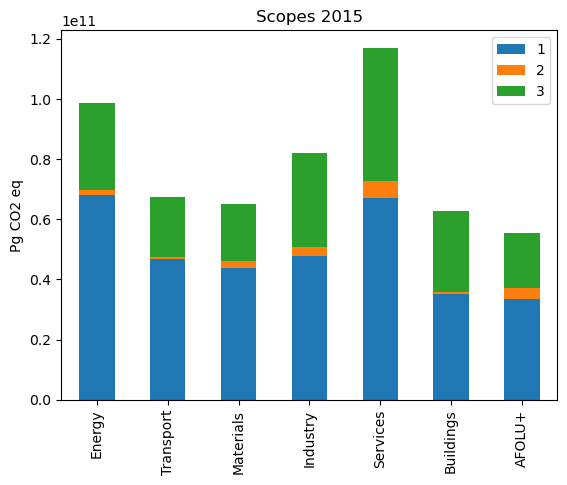

In [22]:
df = pd.DataFrame(
    data=[co2_scope1[20], co2_scope2[20], co2_scope3[20]],
    columns=IPCCagg.columns,
    index=["1", "2", "3"],
)
df.T.plot(kind="bar", stacked=True, ylabel="Pg CO2 eq", title="Scopes 2015")